<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Variational_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Variational Inference on the Test Data

## Importing Packages

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax
from functools import partial
import jax

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

## Load Test Data

In [7]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f')
testy = jnp.load('drive/MyDrive/Project/Test/Testy.npy')
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')

In [8]:
k = jnp.shape(testx)[0]-1
m = jnp.shape(testy)[0] - k - 1
binw = inw/k
timex = jnp.linspace(0.0, k*binw, k+1)
timey = jnp.linspace(0.0, (m+k)*binw, k+m+1)

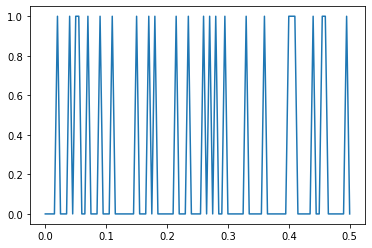

In [9]:
plt.plot(timex, testx)

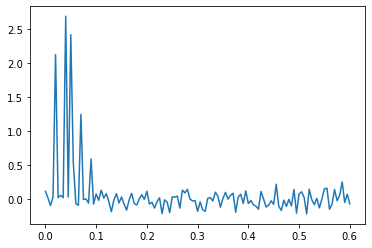

In [10]:
plt.plot(timey, testy)

## Function Definitions

### SE Prior


In [11]:
@jit
def squared_exp2(I, J, Ell, Sigma_f):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [12]:
vec_SE = jit(vmap(vmap(squared_exp2, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

In [13]:
@jit
def root_squared_exp2(I, J, Ell, Sigma_f, Dt):
  return Sigma_f*(2/jnp.pi)**(0.25)*(Dt/Ell)**(0.5)*jnp.exp(-(I-J)**2/Ell**2)

In [14]:
vec_SE_root = jit(vmap(vmap(root_squared_exp2, in_axes=[None,0,None,None, None]),in_axes=[0,None,None,None, None]))

### Cholesky Check

In [15]:
@jit
def checknans(Symmetric_Matrix, Power):
  # Power MUST be input as a float
  M = jnp.shape(Symmetric_Matrix)[0]
  return Symmetric_Matrix, jnp.isnan(jnp.linalg.cholesky(Symmetric_Matrix +
                                                         (10**Power)*jnp.eye(M))).any().astype('f')

In [16]:
@jit
def choleskypwr(Symmetric_Matrix):
  Number_check = 60
  Power_list = -1*jnp.arange(Number_check + 1, dtype='f')
  _, Failure = lax.scan(checknans, Symmetric_Matrix, Power_list)
  return jnp.sum(Failure)

In [17]:
@jit
def broke_Chol(Symmetric_Matrix):
  F_size = jnp.shape(Symmetric_Matrix)[0]
  return jnp.linalg.cholesky(Symmetric_Matrix + 10.0**(-5.0)*jnp.eye(F_size))

In [18]:
@jit
def good_Chol(Symmetric_Matrix):
  return jnp.linalg.cholesky(Symmetric_Matrix)

In [19]:
def choleskyit(Symmetric_Matrix):
  Number_check = 60
  Power_list = -1*jnp.arange(Number_check+1)
  Base_list = 10*jnp.ones(Number_check)
  Lambdas = jnp.power(Base_list, Power_list)
  M = jnp.shape(Symmetric_Matrix)[0]
  Larr = jnp.linalg.cholesky(Symmetric_Matrix).flatten()
  Ind = 1

  while jnp.isnan(Larr).any():
    Larr = jnp.linalg.cholesky(Symmetric_Matrix + Lambdas.at[-Ind].get()*jnp.eye(M)).flatten()
    Ind += 1

  return Larr.reshape((M, M))

### Variational Bound (ELBO)

#### KL Divergence

In [22]:
@jit
def kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu):
  # Not including m/2 term as not being optimised over
  return jnp.sum(jnp.log(jnp.diag(L_matrix))) + 0.5*(jnp.linalg.norm(L_matrix)**2) + \
            0.5*(jnp.linalg.norm(jnp.linalg.lstsq(Prior_cov_root, Mu_prior)[0] - Param_vu)**2)

In [23]:
jax.devices()

In [24]:
jax.device_count()

1

#### Log Multivariate Gaussian PDF

In [25]:
@jit
def logmultivariate_normal(Input, Mean, Covariance_Matrix):
  # Excluding the sqrt(2*pi)**k to avoid overflow
  Diff = Input-Mean
  return -0.5*((Diff.T@jnp.linalg.lstsq(Covariance_Matrix, Diff)[0]) + jnp.log(jnp.linalg.det(Covariance_Matrix)))

In [26]:
#%timeit logmultivariate_normal(jnp.zeros((10000,)), jnp.zeros((10000,)), jnp.eye(10000))

In [27]:
vec_lognorm = jit(vmap(logmultivariate_normal, in_axes = [0, None, None]))

In [28]:
vec_lognorm(jnp.vstack((jnp.ones((10,)), jnp.zeros((10,)))), jnp.zeros((10,)), jnp.eye(10))

DeviceArray([-5., -0.], dtype=float64)

#### Expected Log Likelihood

In [29]:
@jit
def Log_Likely(Sampled_f, Truex, Truey, Sigma_n):

  K = jnp.shape(Truex)[0] - 1
  M = jnp.shape(Truey)[0] - K -1
  
  # Pad input and filter
  X_pad = jnp.hstack((Truex, jnp.zeros((M,))))
  F_pad = jnp.hstack((Sampled_f, jnp.zeros((K,))))

  # Compute the FFTs
  X_fft = jnp.fft.fft(X_pad)
  F_fft = jnp.fft.fft(F_pad)

  # Elementwise multiplication
  FFTmul = jnp.multiply(X_fft, F_fft)

  # Make mean
  Y_mean = jnp.real(jnp.fft.ifft(FFTmul))

  return jsc.stats.multivariate_normal.logpdf(Truey, Y_mean, Sigma_n*jnp.eye(M+K+1))

In [30]:
Log_Likely(jnp.ones((21,)), timex.flatten(), timey.flatten(), 0.05)

DeviceArray(-29424.24175997, dtype=float64)

In [31]:
vec_loglikely = jit(vmap(Log_Likely, in_axes = [1, None, None, None]))

In [32]:
@partial(jit, static_argnums=(0,1))
def Exp_qf(Number_f, Num_Inducing, Subkey, Truex, Truey, Knn, Knm, Kmm, Inducing_Mean, Prior_cov_root, L_matrix, Sigma_n):

  
  # Sampling f
  A = Knm @ jnp.linalg.inv(Kmm)
  F_Mean = A @ Inducing_Mean
  F_Covariance = Knn + A @ (Prior_cov_root @ L_matrix @ L_matrix.T @ Prior_cov_root
                            - Kmm) @ A.T

  F_size = jnp.shape(F_Covariance)[0]
   # Cholesky f covariance
  F_Cholesky = lax.cond(jnp.isnan(jnp.linalg.cholesky(F_Covariance)).any(), broke_Chol, jnp.linalg.cholesky, F_Covariance)

  #Sampled_f = random.multivariate_normal(Subkey, F_Mean, F_Covariance, shape = (Number_f,), method = 'svd')
  Sampled_f = F_Mean.reshape((F_size, 1)) + F_Cholesky@random.normal(Subkey, (F_size, Number_f))
  return jnp.mean(vec_loglikely(Sampled_f, Truex, Truey, Sigma_n), axis = None)

In [33]:
induc_p = timex[::10]

In [34]:
timef = timex[:21]

In [35]:
#exar = [Exp_qf(i, 11, subkeys[-1], timex.flatten(), timey.flatten(), vec_SE(timef, timef, 0.05, 1.0), vec_SE(timef, induc_p, 0.05, 1.0), vec_SE(induc_p, induc_p, 0.05, 1.0), jnp.zeros((11,)), jnp.eye(11), jnp.eye(11), 0.05) for i in np.arange(1, 300000, 10000)]

In [36]:
plt.plot(np.arange(1, 300000, 10000), exar)

NameError: ignored

In [ ]:
print(exar[0])

In [ ]:
#plt.plot(np.arange(1, 30000, 10000), exar)

#### ELBO

In [62]:
@partial(jit, static_argnums=(0,1))
def ELBO(Number_f, Num_Inducing, Subkey, Inducing_Points, L_matrix, Param_vu, 
          Mu_prior, Ell, Sigma_f, Sigma_n, Truex, Truey, Dt, F_locs):
  Knn = vec_SE(F_locs, F_locs, Ell, Sigma_f)
  Knm = vec_SE(F_locs, Inducing_Points, Ell, Sigma_f)
  Kmm = vec_SE(Inducing_Points, Inducing_Points, Ell, Sigma_f)
  Prior_cov_root = vec_SE_root(Inducing_Points, Inducing_Points, Ell, Sigma_f, Dt)

  Inducing_Mean = Prior_cov_root @ Param_vu

  return Exp_qf(Number_f, Num_Inducing, Subkey, Truex, Truey, Knn, Knm, Kmm, Inducing_Mean, Prior_cov_root, L_matrix, Sigma_n)# - \
            #kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu)


In [54]:
knn = vec_SE(f_loc, f_loc, init_l, init_sigma_f)
knm = vec_SE(f_loc, init_inducing_points, init_l, init_sigma_f)
kmm = vec_SE(init_inducing_points, init_inducing_points, init_l, init_sigma_f)
kmmroot = vec_SE_root(init_inducing_points, init_inducing_points, init_l, init_sigma_f, dt)

In [56]:
a = knm @ jnp.linalg.inv(kmm)

In [57]:
f_mean = a @ jnp.zeros(jnp.shape(a)[1])

In [61]:
print(a @ (kmmroot @ L_fill(init_L, num_inducing_points) @ L_fill(init_L, num_inducing_points).T @ kmmroot
                            - kmm) @ a.T)

[[-1.30211537e+00 -6.47384397e-01 -2.47059218e-01 -8.56290260e-02
  -2.91664507e-02 -8.91773568e-03 -2.22196480e-03 -4.43864626e-04
  -6.02829055e-05 -1.48410386e-05  5.82370604e-06 -6.23875920e-06
   5.76226645e-06 -5.36835032e-06  5.03407331e-06 -4.79668859e-06
   4.69088834e-06 -4.75677324e-06  5.01361479e-06 -5.14453374e-06
  -1.25100806e-14]
 [-6.47384397e-01 -4.07114417e-01 -2.32837413e-01 -1.30658497e-01
  -6.58993246e-02 -2.71170451e-02 -8.79518129e-03 -2.21836129e-03
  -4.39712160e-04 -6.56792718e-05 -8.91573983e-06 -1.72091185e-07
  -4.13696930e-07  2.18482400e-07 -1.32733206e-07  7.66136032e-08
  -2.71734026e-08  1.12048946e-07  3.76407498e-07  7.33737295e-09
  -5.14453339e-06]
 [-2.47059218e-01 -2.32837413e-01 -2.15500502e-01 -1.79086750e-01
  -1.21577196e-01 -6.49430411e-02 -2.70703748e-02 -8.78545852e-03
  -2.22325370e-03 -4.36368979e-04 -6.79988192e-05 -7.26460327e-06
  -1.37888338e-06  4.94446916e-07 -4.88677864e-07  4.40348810e-07
  -4.26448017e-07  3.09934569e-07 -7.8

### Make Lower Triangle from L

In [38]:
def L_fill(L_arr, Num_Inducing):
  L_mat = jnp.zeros((Num_Inducing, Num_Inducing))
  mask = jnp.tri(Num_Inducing, dtype=bool)
  L_mat = L_mat.at[mask].set(L_arr)
  return L_mat

### Gradient Ascent

#### Backtracking Search

In [39]:
def backtrack(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LMat, 
                     Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
                     Dt, F_locs):
  Step_size = 1

  while ELBO()


SyntaxError: ignored

In [ ]:
def Grad_Ascent(Inducing_Points, L_Arr, Vu_Init, Mu_Init, Ell_Init, Sigma_f_Init, 
                Sigma_n_Init, Truex, Truey, F_locs, Dt, Epsilon, Subkeys):
  """
    Initial with vectors of:
       - Inducing Points (Initial[:m])
       - L Parameter (Initial[m:m+(m*(m+1)/2)])
       - Vu Parameter (Inital[m+(m*(m+1)/2):2*m+(m*(m+1)/2)])
       - Mu of Prior (Initial[2*m+(m*(m+1)/2): 3*m+(m*(m+1)/2)])
       - Ell of Prior (Initial[2*m+(m*(m+1)/2)])
       - Sigma_f of Prior (Initial[2*m+(m*(m+1)/2)+1])
       - Sigma_n of Prior/Model (Initial[2*m+(m*(m+1)/2)+2])
    
    Truex is the observed input data

    Truey is the observed output data

    Dt is the time resolution

    F_locs is the timestamps of the filter trying to infer    
  """
  Curr_IP = Inducing_Points
  Curr_LA = L_Arr
  Curr_LMat = L_fill(L_Arr, Curr_IP)
  Curr_Vu = Vu_Init
  Curr_Mu = Mu_Init
  Curr_Ell = Ell_Init
  Curr_Sf = Sigma_f_Init
  Curr_Sn = Sigma_n_Init
  Num_Inducing =  jnp.shape(Curr_IP)[0]
  Number_f = 300000
  Subkey_elbo = Subkeys[0]

  while jnp.linalg.norm(Gradient_ELBO)>Epsilon:
    Curr_ELBO = ELBO(Number_f, Num_Inducing, Subkey_elbo, Curr_IP, Curr_LMat, 
                     Curr_Vu, Curr_Mu, Curr_Ell, Curr_Sf, Curr_Sn, Truex, Truey, 
                     Dt, F_locs)  







In [ ]:
def grad_asc_MargL(Epsilon, Initial):
  """
    Initial a vector of:
       - Inducing Points (Initial[:m])
       - L Parameter (Initial[m:m+(m*(m+1)/2)])
       - Vu Parameter (Inital[m+(m*(m+1)/2):2*m+(m*(m+1)/2)])
       - Mu of Prior (Initial[2*m+(m*(m+1)/2): 3*m+(m*(m+1)/2)])
       - Ell of Prior (Initial[3*m+(m*(m+1)/2)])
       - Sigma_f of Prior (Initial[3*m+(m*(m+1)/2)+1])
       - Sigma_n of Prior/Model (Initial[3*m+(m*(m+1)/2)+2])
    
    Truex is the observed input data

    Truey is the observed output data

    F_locs is the timestamps of the filter trying to infer
  """
  Max_Inducing = 10000
  Max_OutV_Len = jnp.rint(0.5*(Max_Inducing**2+5*Max_Inducing))
  Output_Vector = jnp.zeros(0.5*(Max_OutV_Len))

  SizeIn = jnp.shape(Initial)[0]
  Number_Inducing = jnp.rint(0.5*(-5+jnp.sqrt(25+8*SizeIn)))
  Gradient = jnp.ones(SizeIn)
  CurrIn = Initial

  while jnp.linalg.norm(Gradient) > Epsilon:
    Current_ELBO = ELBO(CurrIn)
    Step = -Gradient(CurrIn)

#### Data to test the functions individually

In [44]:
# Generate random key
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 4)
subkeyl = subkeys[0]
subkeysig = subkeys[1]

# Generated test inducing points
num_ind = 10
tstloc = random.truncated_normal(key, 0.0, timey[-1]-timex[-1], (num_ind,))
tstloc = jnp.sort(tstloc)

# Generate covariance of inducing points with SE function (for ease, shouldn't ...
# do this for actual thing)
l_param = random.uniform(subkeyl)
sigma_param = random.uniform(subkeysig)
Gmat = vec_SE(tstloc, tstloc, 0.05, 0.1)

In [45]:
chol_chek = choleskypwr(Gmat)

att = jnp.linalg.cholesky(Gmat)

# Use cond statement to make more efficient
Lnew = jnp.linalg.cholesky(Gmat + chol_chek.any()*(10**(-60+jnp.sum(chol_chek)))*jnp.eye(num_ind))

# Generate arbitrary lower triangular matrix (not from PSD or symmetric)
tstmat = jnp.zeros((4,4))
tstmat = tstmat.at[jnp.tril_indices(4)].set(jnp.arange(1,11).astype('f'))

In [46]:
print(-60+jnp.sum(choleskypwr(Gmat)))

-18.0


In [47]:
print(broke_Chol(Gmat, 60))

TypeError: ignored

In [ ]:
print(checknans(Gmat, 10.0)[1])

In [ ]:
print(jnp.linalg.cholesky(Gmat+10**(-18.0)*np.eye(10)))

In [ ]:
np.isnan(np.linalg.cholesky(Gmat + (10**-50.0)*jnp.eye(10))).any().astype('f')

In [ ]:
print(jnp.linalg.cholesky(Gmat+ 10**(-2)*jnp.eye(10)))

## Running Scripts

### Setting up initial conditions

In [48]:
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 3)

In [49]:
num_inducing_points = 20
init_inducing_points = jnp.linspace(0.0, timey[-1]-timex[-1], num_inducing_points)
init_L = jnp.eye(num_inducing_points).at[jnp.tri(num_inducing_points, dtype=bool)].get()
init_vu = jnp.zeros(num_inducing_points)
init_mu = jnp.zeros(num_inducing_points)
init_l = 0.01
init_sigma_f = 2.0
init_sigma_n = 0.05

In [50]:
testx = testx.flatten()
testy = testy.flatten()
dt = timey[1] - timey[0]
f_loc = jnp.arange(0.0, timey[-1]-timex[-1]+dt, dt) 

In [51]:
print(subkeys[0])

[3186719485 3840466878]


In [52]:
grad_elbo = grad(ELBO, argnums = jnp.arange(3, 10))

In [53]:
ELBO(Number_f, Num_Inducing, Subkey, Inducing_Points, L_matrix, Param_vu, 
          Mu_prior, Ell, Sigma_f, Sigma_n, Truex, Truey, Dt, F_locs):

SyntaxError: ignored

In [63]:
print(grad_elbo(300000, num_inducing_points, subkeys[0], init_inducing_points, L_fill(init_L, num_inducing_points), init_vu, init_mu, init_l, init_sigma_f, init_sigma_n, testx, testy, dt, f_loc))

(DeviceArray([-120568.24422366,  -67210.79973446,  -21667.62924879,
               -2085.00510785,    2547.4964329 ,   -1256.50783864,
                -769.23689429,     272.08670333,   -1623.25816137,
                 396.02037237,    1078.26936114,     310.76827096,
                 271.02627765,   -2311.46278006,    -380.48010729,
                 625.17228244,    4503.2101255 ,   19642.99386079,
               68041.12691228,  119017.42662969], dtype=float64), DeviceArray([[-1866.48018694, -2215.69864927, -2031.75336605,
              -1681.2978789 , -1434.41327119, -1333.71912736,
              -1359.44872077, -1444.70950174, -1496.10754962,
              -1494.70796411, -1472.36590084, -1429.50961799,
              -1340.87003329, -1212.02205685, -1095.76087342,
              -1044.16976837, -1052.97302338, -1071.13999429,
              -1008.05773336,  -774.58231013],
             [-2215.69864927, -2893.05265664, -2929.86928054,
              -2570.45780827, -2171.80765125, -192

In [ ]:
grad_exq = grad(Exp_qf, argnums = jnp.arange(5, 12))

In [ ]:
trygrad = grad_exq(30000, num_inducing_points, subkeys[0], testx, testy, vec_SE(f_loc, f_loc, init_l, init_sigma_f), vec_SE(f_loc, init_inducing_points, init_l, init_sigma_f), 
               vec_SE(init_inducing_points, init_inducing_points, init_l, init_sigma_f), init_mu, vec_SE_root(init_inducing_points, init_inducing_points, init_l, init_sigma_f, dt),
               L_fill(init_L, num_inducing_points), init_sigma_n)

In [ ]:
jnp.shape(trygrad[0])

In [ ]:
print(jnp.shape(f_loc))

In [ ]:
print(L_fill(init_L, num_inducing_points))